In [ ]:
%matplotlib inline
import os
import shutil
import random 
import torch
import torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
torch.manual_seed(0)
print('Using Pytorch version ', torch.__version__)

Using Pytorch version  1.6.0+cu101


In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [ ]:
from torch.utils.data import Dataset 

In [ ]:
class ChestXRayDataset(Dataset):
  def __init__(self, image_dirs, transform):
    def get_images(class_name):
      images = [x for x in os.listdir(image_dirs[class_name]) if x.endswith('png')]
      print(f'Found {len(images)} {class_name} examples')
      return images

    self.images = {}
    self.class_names =  ['normal', 'viral', 'covid']
    for c in self.class_names:
      self.images[c] = get_images(c)

    self.transforms = transform
    self.image_dirs = image_dirs

  def __len__(self):
    return sum([len(self.images[c]) for c in self.class_names])

  def __getitem__(self, index):
    class_name = random.choice(self.class_names)
    index = index % len(self.images[class_name])  
    image_name = self.images[class_name][index]
    image_path = os.path.join(self.image_dirs[class_name], image_name)
    image = Image.open(image_path).convert('RGB')
    return self.transforms(image), self.class_names.index(class_name)

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229, 0.224,0.225])
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229, 0.224,0.225])
])

In [ ]:
train_dirs ={
    'normal':'/content/drive/My Drive/COVID-19 Radiography Database/normal',
    'viral':'/content/drive/My Drive/COVID-19 Radiography Database/viral',
    'covid':'/content/drive/My Drive/COVID-19 Radiography Database/covid'
}

test_dirs = {
    'normal':'/content/drive/My Drive/COVID-19 Radiography Database/test/normal',
    'viral':'/content/drive/My Drive/COVID-19 Radiography Database/test/viral',
    'covid':'/content/drive/My Drive/COVID-19 Radiography Database/test/covid'
}

In [ ]:
train_dataset = ChestXRayDataset(train_dirs, train_transforms)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [ ]:
test_dataset = ChestXRayDataset(test_dirs,test_transforms)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [ ]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset,batch_size = 6, shuffle = True)
print(len(train_dl))

470


In [ ]:
print(len(test_dl))

15


In [ ]:
class_names = train_dataset.class_names
def show_images(images, labels, preds):
  plt.figure(figsize= (8,4))
  for i, image in enumerate(images):
    plt.subplot(1, 6, i+1, xticks=[], yticks=[])
    image = image.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456, 0.406])
    std = np.array([0.229, 0.224,0.225])
    image = image*std + mean
    image= np.clip(image, 0., 1.)
    plt.imshow(image)
    col ='green'
    if preds[i]!=labels[i]:
      col = 'red'
    
    plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
    plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
  plt.tight_layout()
  plt.show()
  

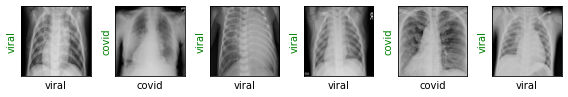

In [ ]:
images, labels = next(iter(train_dl))
show_images(images,labels, labels)

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr = 3e-5)

In [ ]:
def show_preds():
  resnet18.eval()
  images, labels = next(iter(test_dl))
  images = images.to(device)
  labels = labels.to(device)
  outputs = resnet18(images)
  print(outputs.shape)
  _, preds = torch.max(outputs, 1)
  show_images(images.cpu(), labels.cpu(), preds.cpu())

torch.Size([6, 3])


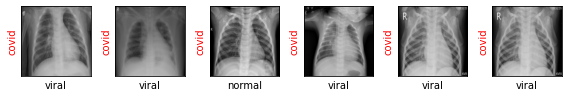

In [ ]:
show_preds()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
if torch.cuda.is_available():
    resnet18.cuda()

In [ ]:
resnet18 = resnet18.to(device)

In [ ]:
def train(epochs):
  print(f'Start training...')
  for e in range(0, epochs):
    print('='*20)
    print(f'Start epoch {e+1}/{epochs}')
    print('='*20)
    train_loss = 0
    resnet18.train()
    for train_step, (images, labels) in enumerate(train_dl):
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = resnet18(images)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      if train_step % 20 == 0:
        print('Evaluating at step', train_step)
        resnet18.eval()
        acc = 0.
        val_loss = 0.
        for val_step, (images, labels) in enumerate(test_dl):
          images = images.to(device)
          labels = labels.to(device)
          outputs = resnet18(images)
          loss = loss_fn(outputs, labels)
          val_loss += loss.item()

          _, preds = torch.max(outputs, 1)
          acc += sum((preds == labels))
        
        val_loss = val_loss/(val_step+1)
        acc = acc / len(test_dataset)
        print(f'Val loss:{val_loss:.4f}, Accuracy:{acc:.4f}')
        show_preds()
        resnet18.train()

        if acc > 0.95:
          print('Perfomance level satisfied...')
          return

    train_loss = train_loss/len(train_step+1)
    print(f'Training loss: {train_loss:.4f}')      

Start training...
Start epoch 1/1
Evaluating at step 0
Val loss:1.1092, Accuracy:0.4000
torch.Size([6, 3])


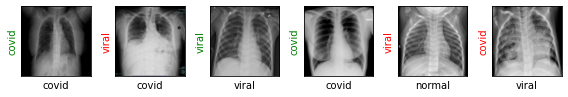

Evaluating at step 20
Val loss:0.6115, Accuracy:0.8000
torch.Size([6, 3])


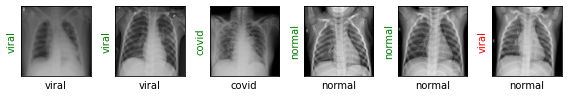

Evaluating at step 40
Val loss:0.3676, Accuracy:0.9111
torch.Size([6, 3])


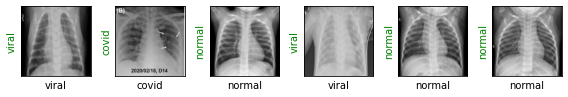

Evaluating at step 60
Val loss:0.2253, Accuracy:0.9222
torch.Size([6, 3])


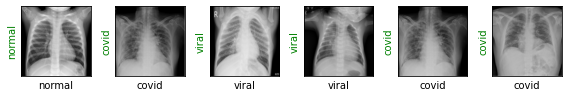

Evaluating at step 80
Val loss:0.2004, Accuracy:0.9111
torch.Size([6, 3])


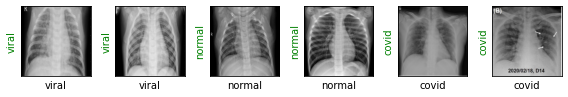

Evaluating at step 100
Val loss:0.1920, Accuracy:0.9333
torch.Size([6, 3])


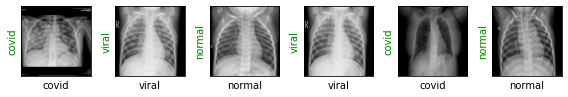

Evaluating at step 120
Val loss:0.2146, Accuracy:0.9111
torch.Size([6, 3])


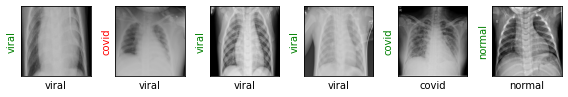

Evaluating at step 140
Val loss:0.1560, Accuracy:0.9444
torch.Size([6, 3])


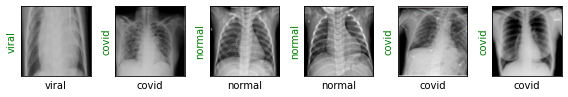

Evaluating at step 160
Val loss:0.2095, Accuracy:0.9111
torch.Size([6, 3])


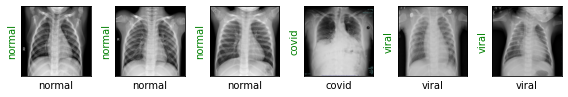

Evaluating at step 180
Val loss:0.1881, Accuracy:0.9333
torch.Size([6, 3])


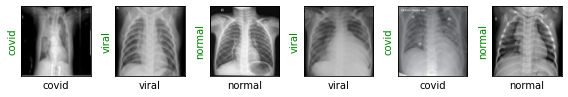

Evaluating at step 200
Val loss:0.3127, Accuracy:0.8889
torch.Size([6, 3])


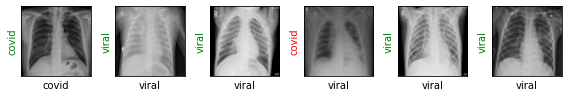

Evaluating at step 220
Val loss:0.1628, Accuracy:0.9556
torch.Size([6, 3])


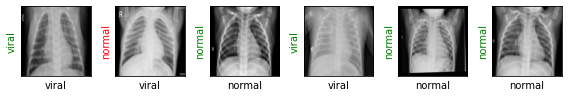

Perfomance level satisfied...


In [ ]:
train(epochs = 1)

torch.Size([6, 3])


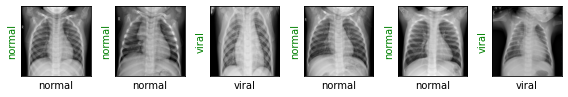

In [ ]:
show_preds()